In [22]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.filterwarnings(action='ignore')

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

# optimizer
from tensorflow.keras import optimizers
# define model
from tensorflow.keras.models import Sequential, Model
# layer function(elements)1
from tensorflow.keras.layers import Conv1D, MaxPooling1D
# layer function(elements)2
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
# MSE loss function
from sklearn.metrics import mean_squared_error
# dateset split function
from sklearn.model_selection import train_test_split

%matplotlib inline
import tensorflow as tf
from numpy.random import seed
tf.random.set_seed(1)
seed(1)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [24]:
df = pd.read_csv('./dataset/ella/2023년 10월 엘니뇨 라니냐지수.csv')

df = df[['WTCH_YM','ENN_LNN_MNTH_AVG_VAL']]

df['WTCH_YM'] = pd.to_datetime(df['WTCH_YM'], format='%Y%m') # assume format YYYYMM
print(df.head())


     WTCH_YM  ENN_LNN_MNTH_AVG_VAL
0 1982-01-01             26.583536
1 1982-02-01             26.455164
2 1982-03-01             27.034367
3 1982-04-01             27.782887
4 1982-05-01             28.324877


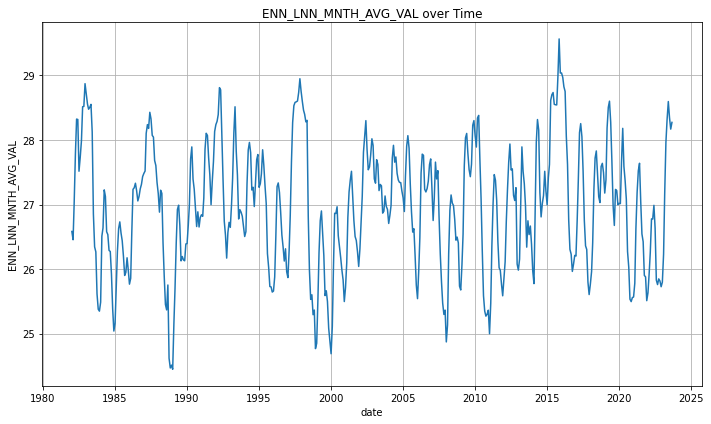

In [25]:
# drawing
plt.figure(figsize=(10, 6))
plt.plot(df.WTCH_YM, df.ENN_LNN_MNTH_AVG_VAL)
plt.xlabel('date')
plt.ylabel('ENN_LNN_MNTH_AVG_VAL')
plt.title('ENN_LNN_MNTH_AVG_VAL over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
train_df = df[df['WTCH_YM'] < '2020-01-01']
test_df = df[df['WTCH_YM'] >= '2020-01-01']

In [27]:
def make_series(data, window=1, dropnan=True):
    cols, names = [], []
    
    for i in range(window, 0, -1):
        cols.append(data.shift(i)) # shift: 행의 위치를 이동 [양수: 아래, 음수: 위]
        names += [f'{col_name}(t-{i})' for col_name in data.columns]
    
    cols.append(data)
    names += [f'{col}(t)' for col in data.columns]
    
    cols.append(data.shift(-1))
    names += [f'{col}(t+1)' for col in data.columns]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [28]:
window = 11
series = make_series(train_df.drop('WTCH_YM', axis=1), window=window)
print(series.head())

labels_col = 'ENN_LNN_MNTH_AVG_VAL(t+1)' # label is t+1 
labels = series[labels_col]
series.drop(labels_col, axis=1, inplace=True)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print(X_train.head())

    ENN_LNN_MNTH_AVG_VAL(t-11)  ENN_LNN_MNTH_AVG_VAL(t-10)  ENN_LNN_MNTH_AVG_VAL(t-9)  ENN_LNN_MNTH_AVG_VAL(t-8)  ENN_LNN_MNTH_AVG_VAL(t-7)  ENN_LNN_MNTH_AVG_VAL(t-6)  ENN_LNN_MNTH_AVG_VAL(t-5)  ENN_LNN_MNTH_AVG_VAL(t-4)  ENN_LNN_MNTH_AVG_VAL(t-3)  ENN_LNN_MNTH_AVG_VAL(t-2)  ENN_LNN_MNTH_AVG_VAL(t-1)  ENN_LNN_MNTH_AVG_VAL(t)  ENN_LNN_MNTH_AVG_VAL(t+1)
11                   26.583536                   26.455164                  27.034367                  27.782887                  28.324877                  28.318243                  27.516779                  27.732350                  27.988077                  28.516157                  28.520609                28.873512                  28.718626
12                   26.455164                   27.034367                  27.782887                  28.324877                  28.318243                  27.516779                  27.732350                  27.988077                  28.516157                  28.520609                  

In [29]:
# given y_true, y_pred list, calculate r2, corr, mape, rmse than return result with df
def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    corr = round(np.corrcoef(y_true, y_pred)[0, 1], 3)
    mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)
    
    df = pd.DataFrame({
        'R2': r2,
        "Corr": corr,
        "RMSE": rmse,
        "MAPE": mape
    }, index=[0]) # 1행 데이터이므로 index를 0 하나만 부여
    return df

In [30]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
def MinMax(y_true, y_pred, m='min'):
    if m == 'min':
        return min(min(y_true), min(y_pred)) - 2
    else:
        return max(max(y_true), max(y_pred)) + 2
    
# x = date, y = MeanTemp
def myGraph(temp, title):
    fig, axs = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [2.5, 1]})
    axs[0].plot(temp['WTCH_YM'], temp['y_true'], label = 'Original')
    axs[0].plot(temp['WTCH_YM'], temp['y_pred'], label = 'Predicted')
    axs[0].legend(loc='upper right')
    axs[0].title.set_text(title)
    axs[0].set_xlabel('WTCH_YM')
    axs[0].set_ylabel('ENN_LNN_MNTH_AVG_VAL')
    
    axs[1].plot(temp.y_true, temp.y_pred, '.')
    plt.xlim(MinMax(temp.y_true, temp.y_pred), MinMax(temp.y_true, temp.y_pred, 'max'))
    plt.ylim(MinMax(temp.y_true, temp.y_pred), MinMax(temp.y_true, temp.y_pred, 'max'))
    abline(1,0)
    plt.title(title)
    plt.xlabel('Original')
    plt.ylabel('Predicted')
    

In [39]:
epochs = 100
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)
#(n, 12) -> (n, 12, 1)
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

# LSTM

In [32]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

variables = model_lstm.trainable_variables


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)

Y_train_ = pd.DataFrame({'y_true': Y_train, 'y_pred': lstm_train_pred.reshape(lstm_train_pred.shape[0],)}).set_index(X_train.index).sort_index()
#merge by using index
Y_train_ = pd.merge(Y_train_, train_df, left_index=True, right_index=True, how='left')

Y_valid_ = pd.DataFrame({'y_true': Y_valid, 'y_pred': lstm_valid_pred.reshape(lstm_valid_pred.shape[0],)}).set_index(X_valid.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_df, left_index=True, right_index=True, how='left')

Epoch 1/100
9/9 - 0s - loss: 0.5748 - val_loss: 0.5472 - 417ms/epoch - 46ms/step
Epoch 2/100
9/9 - 0s - loss: 0.5671 - val_loss: 0.5467 - 347ms/epoch - 39ms/step
Epoch 3/100
9/9 - 0s - loss: 0.6060 - val_loss: 0.5465 - 311ms/epoch - 35ms/step
Epoch 4/100
9/9 - 0s - loss: 0.5740 - val_loss: 0.5505 - 302ms/epoch - 34ms/step
Epoch 5/100
9/9 - 0s - loss: 0.5618 - val_loss: 0.5274 - 296ms/epoch - 33ms/step
Epoch 6/100
9/9 - 0s - loss: 0.5505 - val_loss: 0.5219 - 297ms/epoch - 33ms/step
Epoch 7/100
9/9 - 0s - loss: 0.5449 - val_loss: 0.5211 - 296ms/epoch - 33ms/step
Epoch 8/100
9/9 - 0s - loss: 0.5450 - val_loss: 0.5125 - 324ms/epoch - 36ms/step
Epoch 9/100
9/9 - 0s - loss: 0.5290 - val_loss: 0.5084 - 300ms/epoch - 33ms/step
Epoch 10/100
9/9 - 0s - loss: 0.5269 - val_loss: 0.5036 - 292ms/epoch - 32ms/step
Epoch 11/100
9/9 - 0s - loss: 0.5172 - val_loss: 0.4992 - 291ms/epoch - 32ms/step
Epoch 12/100
9/9 - 0s - loss: 0.5187 - val_loss: 0.4971 - 292ms/epoch - 32ms/step
Epoch 13/100
9/9 - 0s - l

In [ ]:
scoring(Y_train_.y_true, Y_train_.y_pred)

In [ ]:
scoring(Y_valid_.y_true, Y_valid_.y_pred)

Obs of Valid Set:  178


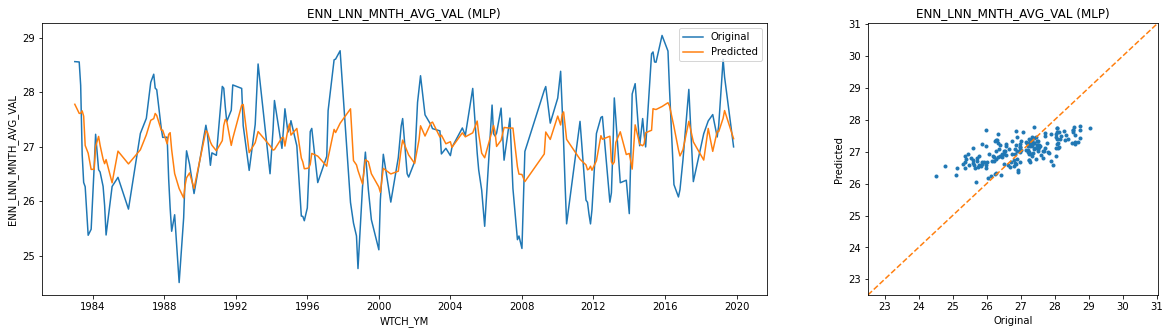

In [36]:
print('Obs of Valid Set: ', Y_valid_.shape[0])
myGraph(Y_valid_, 'ENN_LNN_MNTH_AVG_VAL (MLP)')

# TEST

In [37]:
test_series = make_series(test_df.drop('WTCH_YM', axis=1), window=window)
test_labels = test_series[labels_col]
test_series = test_series.drop(labels_col, axis=1)

X_test = test_series
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# subsequences = 2
# timesteps = X_test_series.shape[1] // subsequences
# X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, 1))

Y_test = test_labels.values

lstm_test_pred = model_lstm.predict(X_test_series)

Y_test_ = pd.DataFrame({'y_true': Y_test, 'y_pred': lstm_test_pred.reshape(lstm_test_pred.shape[0],)}).set_index(X_test.index).sort_index()
Y_test_ = pd.merge(Y_test_, test_df, left_index=True, right_index=True, how='left')

scoring(Y_test_.y_true, Y_test_.y_pred)

,R2,Corr,RMSE,MAPE
0,27.622,0.724,0.803,2.612


Obs of Test Set:  33


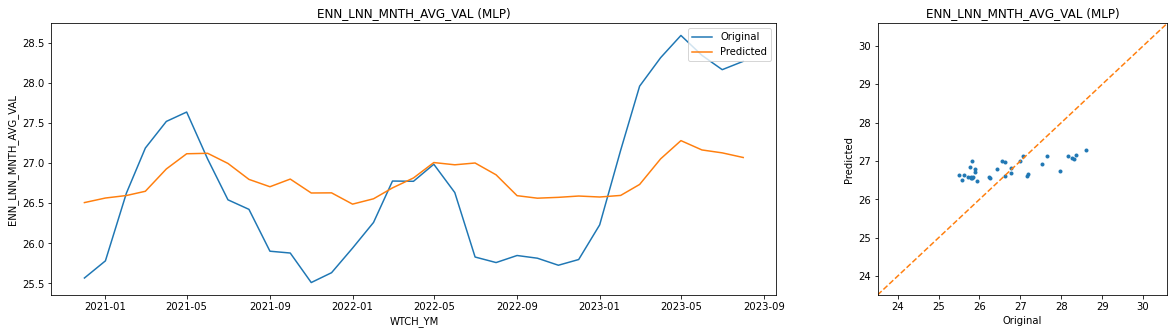

In [38]:
print('Obs of Test Set: ', Y_test_.shape[0])
myGraph(Y_test_, 'ENN_LNN_MNTH_AVG_VAL (MLP)')